C:\Users\tsenz\AppData\Local\Temp\ipykernel_8844\3987709324.py:217: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


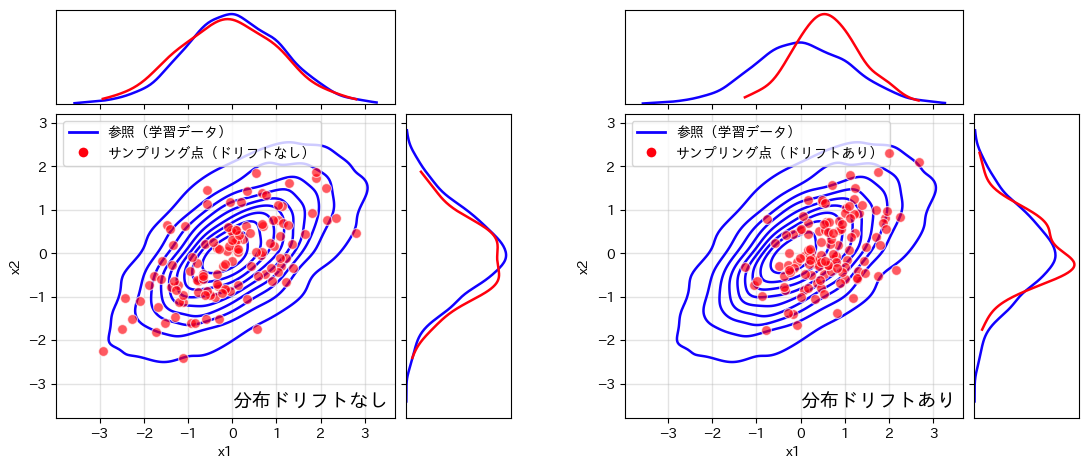

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
from matplotlib.lines import Line2D

# ============================================================
# 0) 色・見た目（ここだけ触ればOK）
# ============================================================
REF_COLOR = "#1100ff"              # 参照（学習データ）等高線・周辺KDE
TEST_NO_DRIFT_COLOR = "#FF000D"    # 左：ドリフトなし（点）
TEST_DRIFT_COLOR = "#FF000D"       # 右：ドリフトあり（点）
OUTLIER_COLOR = "#FF000D"          # 外れ値（少数）の色

TEST_POINT_ALPHA = 0.65
TEST_POINT_SIZE  = 50
TEST_POINT_EDGE  = "w"
TEST_POINT_LW    = 0.8
KDE_LW = 1.8

# ============================================================
# 1) データ生成（正規分布ベース：相関あり）
#   ポイント：
#   - 外れ値（少数）は左右で「同じ個数」にして、"外れ値が増えた" ではないことを担保
#   - 右は「正常範囲内っぽい」まま、中心/相関が少しズレて分布がドリフト
# ============================================================
rng = np.random.default_rng(42)

def mvn(n, mu, cov):
    return rng.multivariate_normal(mu, cov, size=n)

n_ref  = 2000
n_test = 120

# 参照：相関付き正規分布
mu_ref = np.array([0.0, 0.0])
cov_ref = np.array([[1.2, 0.65],
                    [0.65, 1.0]])
ref = mvn(n_ref, mu_ref, cov_ref)

def clip_to_ref_quantile(test, ref, q=(0.003, 0.997)):
    """正常範囲内っぽさ：参照の分位点レンジに軽く収める（外れ値には適用しない）"""
    lo = np.quantile(ref, q[0], axis=0)
    hi = np.quantile(ref, q[1], axis=0)
    out = test.copy()
    out[:, 0] = np.clip(out[:, 0], lo[0], hi[0])
    out[:, 1] = np.clip(out[:, 1], lo[1], hi[1])
    return out

# --- 外れ値（少数）を作る設定（左右で同数） ---
K_OUT = 8  # ← 外れ値の個数（左右で同じ）
out_mu  = np.array([1.6, -1.3])          # 外れ値の中心（参照の等高線から少し外へ）
out_cov = np.array([[0.05, 0.00],
                    [0.00, 0.05]])       # 外れ値は小さく固める（見やすく）

# 左：ドリフトなし（参照データを少しだけ揺らす）
idx = rng.choice(n_ref, size=n_test, replace=False)
test_noise_normal = ref[idx] + rng.normal(loc=0.0, scale=[0.12, 0.12], size=(n_test, 2))
test_noise_normal = clip_to_ref_quantile(test_noise_normal, ref)

# 右：ドリフト（中心と相関が “少しだけ” ズレる：ただし範囲は大きく外さない）
# ここが「分布ドリフト」に見える本体のパラメータ
# 右：ドリフト（中心は同じ、ばらつきを狭くして "まとまってズレた" を強調）
mu_drift  = np.array([0.6, 0.10])
cov_base  = np.array([[1.05, 0.45],
                      [0.45, 0.95]])

SHRINK = 0.6   # ← 0.4〜0.7で調整（小さいほど点群が締まる）
cov_drift = SHRINK * cov_base

test_drift_normal = mvn(n_test, mu_drift, cov_drift)
test_drift_normal = clip_to_ref_quantile(test_drift_normal, ref)


# 外れ値（少数）は左右で同数・同分布（＝増えていない）
out_noise = mvn(K_OUT, out_mu, out_cov)
out_drift = mvn(K_OUT, out_mu, out_cov)

# ============================================================
# 2) 軸範囲：参照 + 正常テスト + 外れ値 まで含めて切れない範囲に固定
# ============================================================
all_data = np.vstack([ref, test_noise_normal, test_drift_normal, out_noise, out_drift])
xmin, xmax = all_data[:, 0].min(), all_data[:, 0].max()
ymin, ymax = all_data[:, 1].min(), all_data[:, 1].max()
pad_ratio = 0.06
xpad = (xmax - xmin) * pad_ratio
ypad = (ymax - ymin) * pad_ratio
xlim = (xmin - xpad, xmax + xpad)
ylim = (ymin - ypad, ymax + ypad)

# ============================================================
# 3) タイル（jointplot配置をGridSpecで再現）
#   - 中央：参照の等高線（背面）
#   - 中央：正常点（前面）
#   - 中央：外れ値（さらに前面、マーカーを変えて強調）
# ============================================================
def draw_tile(fig, cell, ref, normal_pts, outliers, *, tag_text, ref_color, test_color, test_label):
    sub = cell.subgridspec(
        2, 2,
        width_ratios=[4.5, 1.4],
        height_ratios=[1.4, 4.5],
        wspace=0.05, hspace=0.05
    )
    ax_top   = fig.add_subplot(sub[0, 0])
    ax_joint = fig.add_subplot(sub[1, 0], sharex=ax_top)
    ax_right = fig.add_subplot(sub[1, 1], sharey=ax_joint)

    # 上：x周辺KDE（参照 vs 正常テスト）
    sns.kdeplot(x=ref[:, 0],        ax=ax_top,   color=ref_color,  linewidth=KDE_LW, cut=0, zorder=1)
    sns.kdeplot(x=normal_pts[:, 0], ax=ax_top,   color=test_color, linewidth=KDE_LW, cut=0, zorder=2)
    ax_top.set_ylabel("")
    ax_top.set_yticks([])

    # 右：y周辺KDE（参照 vs 正常テスト）
    sns.kdeplot(y=ref[:, 1],        ax=ax_right, color=ref_color,  linewidth=KDE_LW, cut=0, zorder=1)
    sns.kdeplot(y=normal_pts[:, 1], ax=ax_right, color=test_color, linewidth=KDE_LW, cut=0, zorder=2)
    ax_right.set_xlabel("")
    ax_right.set_xticks([])

    # 中央：参照の2D KDE等高線（背面）
    sns.kdeplot(
        x=ref[:, 0], y=ref[:, 1],
        ax=ax_joint,
        levels=10,
        fill=False,
        color=ref_color,
        linewidths=KDE_LW,
        zorder=1
    )

    # 中央：正常点（最前面寄り）
    ax_joint.scatter(
        normal_pts[:, 0], normal_pts[:, 1],
        s=TEST_POINT_SIZE,
        alpha=TEST_POINT_ALPHA,
        color=test_color,
        edgecolors=TEST_POINT_EDGE,
        linewidths=TEST_POINT_LW,
        zorder=10
    )

    # # 中央：外れ値（さらに前面・マーカーを変えて強調）
    # ax_joint.scatter(
    #     outliers[:, 0], outliers[:, 1],
    #     s=TEST_POINT_SIZE * 1.2,
    #     alpha=0.95,
    #     color=OUTLIER_COLOR,
    #     marker="X",
    #     edgecolors="w",
    #     linewidths=0.9,
    #     zorder=20
    # )

    # 軸範囲固定（左右で完全一致）
    ax_joint.set_xlim(xlim)
    ax_joint.set_ylim(ylim)

    ax_joint.set_xlabel("x1")
    ax_joint.set_ylabel("x2")

    # グリッド（中央だけくっきり）
    ax_joint.set_axisbelow(True)
    ax_joint.grid(True, which="major", alpha=0.35, linewidth=1.0)
    ax_joint.grid(True, which="minor", alpha=0.18, linewidth=0.7)

    # 図中タグ
    ax_joint.text(
        0.98, 0.02, tag_text,
        transform=ax_joint.transAxes, ha="right", va="bottom",
        fontsize=14
    )

    # 凡例（手動）
    handles = [
        Line2D([0], [0], color=ref_color, lw=2, label="参照（学習データ）"),
        Line2D([0], [0], marker="o", linestyle="None",
               markerfacecolor=test_color, markeredgecolor=TEST_POINT_EDGE,
               markersize=8, label=test_label),
        # Line2D([0], [0], marker="X", linestyle="None",
        #        markerfacecolor=OUTLIER_COLOR, markeredgecolor="w",
        #        markersize=9, label="外れ値（少数）"),
    ]
    ax_joint.legend(handles=handles, loc="upper left", frameon=True)

    # 共有軸の都合で不要な目盛りを消す
    plt.setp(ax_top.get_xticklabels(), visible=False)
    plt.setp(ax_right.get_yticklabels(), visible=False)

# ============================================================
# 4) 2タイル横並びで描画
# ============================================================
fig = plt.figure(figsize=(13.2, 5.3))
outer = fig.add_gridspec(1, 2, wspace=0.25)

draw_tile(
    fig, outer[0],
    ref=ref,
    normal_pts=test_noise_normal,
    outliers=out_noise,
    tag_text="分布ドリフトなし",
    ref_color=REF_COLOR,
    test_color=TEST_NO_DRIFT_COLOR,
    test_label="サンプリング点（ドリフトなし）"
)

draw_tile(
    fig, outer[1],
    ref=ref,
    normal_pts=test_drift_normal,
    outliers=out_drift,
    tag_text="分布ドリフトあり",
    ref_color=REF_COLOR,
    test_color=TEST_DRIFT_COLOR,
    test_label="サンプリング点（ドリフトあり）"
)

fig.tight_layout()
plt.show()
